In [1]:
# Importing libraries
import math
import numpy as np
from scipy.special import ndtri
from numpy.linalg import solve
from numpy.linalg import cholesky
from numpy.linalg import LinAlgError
from functools import partial
from scipy import integrate
from scipy.optimize import broyden1, broyden2, newton_krylov, fixed_point, fsolve, minimize, least_squares, minimize_scalar
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal, norm 
import pickle
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

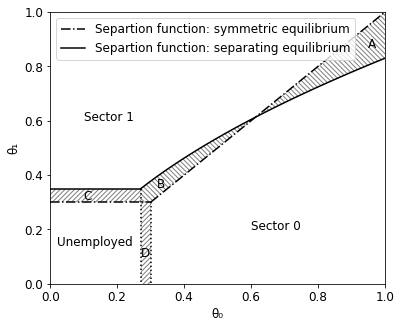

In [2]:
# Plot describing equilibria for different values of the correlation parameter and AMH copula
subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
d = np.arange(0.3, 1.05, 0.025)
dd = np.arange(0.27, 1.05, 0.025)
ddd = np.arange(0.27, 0.31, 0.01)
dddd = np.arange(0, 0.271, 0.01)
ddddd = np.arange(0.27, 0.31, 0.01)
fig, ax = plt.subplots(figsize=(6, 5))


for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

def f1(x):
    return x
def f2(x):
    return x**(0.5)-0.17

vecfunc1 = np.vectorize(f1)
ax.plot(d,vecfunc1(d), label='Separtion function: symmetric equilibrium',linestyle='dashdot',color='black')

vecfunc2 = np.vectorize(f2)
ax.plot(dd,vecfunc2(dd), label='Separtion function: separating equilibrium',color='black')
plt.plot([0, 0.3], [0.3, 0.3], color='black',linestyle='dashdot')
plt.plot([0.3, 0.3], [0.3, 0],color='black', linestyle='dotted')
plt.plot([0, 0.27], [(0.3**(0.5)-0.2), (0.3**(0.5)-0.2)],color='black')
plt.plot([0.27, 0.27], [(0.3**(0.5)-0.2), 0],color='black', linestyle='dotted')
plt.text(0.02, 0.14, 'Unemployed', fontsize=12)
plt.text(0.1, 0.6, 'Sector 1', fontsize=12)
plt.text(0.6, 0.2, 'Sector 0', fontsize=12)
plt.text(0.95, 0.87, 'A', fontsize=12)
plt.text(0.32, 0.355, 'B', fontsize=12)
plt.text(0.1, 0.31, 'C', fontsize=12)
plt.text(0.2723, 0.1, 'D', fontsize=12)
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('θ0'.translate(subscript))
ax.set_ylabel('θ1'.translate(subscript))
ax.legend(loc='upper left',prop={'size': 12})
plt.fill_between(d, f1(d), f2(d), where=f1(d)>=f2(d), interpolate=True,color="none", hatch="\\\\\\\\\\", edgecolor="grey", linewidth=0.0,alpha=1)
plt.fill_between(d, f1(d), f2(d), where=f1(d)<=f2(d), interpolate=True,color="none", hatch="\\\\\\\\\\", edgecolor="grey", linewidth=0.0,alpha=1)
plt.fill_between(ddd, 0.3, f2(ddd), where=0.27<=f2(ddd), interpolate=True,color="none", hatch="\\\\\\\\\\", edgecolor="grey", linewidth=0.0,alpha=1)
plt.fill_between(dddd, 0.3, 0.35, interpolate=True,color="none", hatch="/////", edgecolor="grey", linewidth=0.0,alpha=1)
plt.fill_between(ddddd, 0, 0.3, interpolate=True,color="none", hatch="/////", edgecolor="grey", linewidth=0.0,alpha=1)
plt.savefig('isf.pdf')

In [2]:
# Gaussian copula pdf
def _gaussian(x,y, kappa):
    R = cholesky([[1,kappa],[kappa,1]])
    x = ndtri([x,y])
    z = solve(R,x.T)
    log_det= np.sum(np.log(np.diag(R)))
    return np.exp(-0.5 * np.sum(  np.power(z,2) - np.power(x,2) ) - log_det)

In [3]:
# Calculate equilibrium sufficent statistic and varius helper functions

def acop(x,y,kappa):
    if normd == 0:
        return ( 1 + kappa * ((1+x)*(1+y)-3) + (kappa**2)*(1-x)*(1-y)) / ((1-kappa*(1-x)*(1-y))**3)
    elif normd == 1:
        return _gaussian(x,y, kappa)
    return 

def func_b(k,m):
    out, err = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0,1, lambda x: np.maximum(np.minimum(m + x * k,1),0), 1)
    return out -1/2

def det_m(k):
    return least_squares(partial(func_b,k),  [0],  bounds=[-5,5]).x[0]

def func_mx(x0,x1,m):
    out, err = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0,1, lambda x: np.maximum(np.minimum(m + x * x0/x1,1),0), 1)
    ans1, err1 = integrate.dblquad(lambda x,y: x*acop(x,y,kappa), 0 , 1, lambda x: m + x *x0/x1, 1 )
    ans0, err0 = integrate.dblquad(lambda x,y: y*acop(x,y,kappa), 0,1 , 0, lambda x: m + x * x0/x1 )
    return np.array([2*ans0, 2*ans1, out])

def equilibrium_solve(guess):
    return least_squares(lambda x: func_mx(x[0],x[1],x[2])-np.array([x[0],x[1],1/2]),  guess, bounds=[[0.1,0.1,0.01],[0.9,0.9, 0.25]])

def func_x(k):
    k = np.minimum(1,k)
    m = det_m(k)
    ans1, err1 = integrate.dblquad(lambda x,y: x*acop(x,y,kappa), 0 , 1, lambda x: m + x * k,  1)
    ans0, err0 = integrate.dblquad(lambda x,y: y*acop(x,y,kappa), 0,1 , 0, lambda x: m + x * k )
    return ans0/ans1

def func_y(k,m):
    ans1, err1 = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0 , 1, lambda x: m + x * k,  1)
    ans0, err0 = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0,1 , 0, lambda x: m + x * k )
    return ans0, ans1

In [ ]:
# Plot describing equilibria for different values of the correlation parameter and gaussian copula

subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
d = np.arange(0.4, 1.05, 0.05)
fig, ax = plt.subplots(figsize=(6, 5))

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
normd=1

vecfunc1 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc1(d),color='black')
print('arg0')
a = 'ρ = 0.7'
kappa=0.7
vecfunc2 = np.vectorize(func_x)
ax.plot(d,vecfunc2(d),label=a,color='black', linestyle='dotted')
print('arg1')
a =  'ρ = 0.5'
kappa=0.5
vecfunc3 = np.vectorize(func_x)
ax.plot(d,vecfunc3(d),label=a,color='black', linestyle='dashed')
print('arg2')
a = 'ρ = 0'
kappa=0
vecfunc5 = np.vectorize(func_x)
ax.plot(d,vecfunc5(d),label=a,color='black', linestyle='dashdot')


ax.set_ylim([0.4, 1])
ax.set_xlim([0.4, 1])
#ax.set_title("Illustration separate equilibrium - Gaussian copula")  
ax.set_xlabel('κ')
ax.set_ylabel('g0(κ)/g1(κ)'.translate(subscript))
ax.legend()
plt.savefig('gc223.png')

In [6]:
normd = 1
kappa = 0.5
xx = equilibrium_solve([0.45, 0.67, 0.1])
#least_squares(lambda k: func_x(k)-k,  [0.81], bounds=[0.75,0.85])
xx

 active_mask: array([0, 0, 0])
        cost: 7.527420000028574e-17
         fun: array([ 3.53259089e-10, -1.22639441e-08,  1.38865253e-10])
        grad: array([ 1.75167500e-08, -2.23375658e-09,  1.81199149e-08])
         jac: array([[ 0.5076986 , -1.22371741,  1.45095536],
       [-1.42584769,  0.15676001, -1.45213373],
       [-1.07381366,  0.87155543, -1.45129974]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 8
        njev: 8
  optimality: 7.856001995410544e-09
      status: 1
     success: True
           x: array([0.54848513, 0.67576908, 0.0941771 ])

In [7]:
normd = 1
kappa = 0.7
#newton_krylov(lambda k: func_x(k)-k,  [0])
xx2 = equilibrium_solve([0.4, 0.7, 0.15])
xx2

 active_mask: array([0, 0, 0])
        cost: 5.069184499684101e-20
         fun: array([ 7.64399655e-12, -3.18255977e-10,  6.19615470e-12])
        grad: array([3.95876879e-10, 6.85373565e-11, 4.75328857e-10])
         jac: array([[ 0.39315236, -0.85589595,  1.4869555 ],
       [-1.25472886, -0.22345267, -1.48678054],
       [-1.04150665,  0.63986033, -1.48708667]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 7
        njev: 7
  optimality: 1.340430553352787e-10
      status: 1
     success: True
           x: array([0.43859784, 0.71391105, 0.19282039])

In [ ]:
out1 = pd.DataFrame([xx])
out2 = pd.DataFrame([xx2])
out1.to_pickle("eq1")
out2.to_pickle("eq2")  

In [8]:
#Check condtion for comparative static result
normd = 1
kappa = 0.7
y = func_mx(xx.x[0],xx.x[1],xx.x[2])
func_y(xx.x[0]/xx.x[1],xx.x[2]), func_y(y[0]/y[1],xx.x[2])

((0.4999999998573804, 0.5000000001316189),
 (0.44111365522565343, 0.558886344756819))

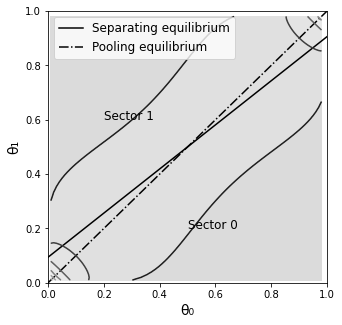

In [15]:
# Contour plot and equilibria distributions Gaussian copula ρ = 0.5
kappa = 0.5
k = xx.x[0]/xx.x[1]
m = xx.x[2]



fig, ax = plt.subplots(figsize=(5, 5))
d = np.arange(0, 1, 0.001)
vecfunc = np.vectorize(lambda x: (x-(1-k)/2)/k)
vecfunc2 = np.vectorize(lambda x: x)
x = np.arange(0.01,0.99,0.01)
y = np.arange(0.01,0.99,0.01)
X, Y = np.meshgrid(x,y)


zs = []
for i in np.arange(0.01,0.99,0.01):
    for j in np.arange(0.01,0.99,0.01):
        zs.append(acop(i,j,kappa))
zs = np.array(zs)
Z = zs.reshape(X.shape)
ax.contourf(X, Y, Z, cmap=plt.cm.gray,alpha=0.15)



ax.plot(vecfunc(d),d,label='Separating equilibrium',color='black')
vecfunc2 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc2(d), label='Pooling equilibrium',linestyle='dashdot',color='black')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('θ0'.translate(subscript))
ax.set_ylabel('θ1'.translate(subscript))
ax.legend(loc='upper left',prop={'size': 12})
plt.text(0.2, 0.6, 'Sector 1', fontsize=12)
plt.text(0.5, 0.2, 'Sector 0', fontsize=12)
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14)    
plt.contour(X,Y,Z)
plt.gray()
#plt.suptitle("Skill separation in competitive equilibria") 
plt.savefig('eqsepss05.pdf')

In [ ]:
# Contour plot and equilibria distributions Gaussian copula ρ = 0.5
kappa = 0.5
k = xx.x[0]/xx.x[1]
m = xx.x[2]



fig, ax = plt.subplots(figsize=(5, 5))
d = np.arange(0, 1, 0.001)
vecfunc = np.vectorize(lambda x: (x-(1-k)/2)/k)
vecfunc2 = np.vectorize(lambda x: x)
x = np.arange(0.01,0.99,0.01)
y = np.arange(0.01,0.99,0.01)
X, Y = np.meshgrid(x,y)


zs = []
for i in np.arange(0.01,0.99,0.01):
    for j in np.arange(0.01,0.99,0.01):
        zs.append(acop(i,j,kappa))
zs = np.array(zs)
Z = zs.reshape(X.shape)
ax.contourf(X, Y, Z, cmap=plt.cm.gray,alpha=0.15)



ax.plot(vecfunc(d),d,label='Separating equilibrium',color='black')
vecfunc2 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc2(d), label='Pooling equilibrium',linestyle='dashdot',color='black')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('θ0'.translate(subscript))
ax.set_ylabel('θ1'.translate(subscript))
ax.legend(loc='upper left',prop={'size': 12})
plt.text(0.2, 0.6, 'Sector 1', fontsize=12)
plt.text(0.5, 0.2, 'Sector 0', fontsize=12)
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14)    
plt.contour(X,Y,Z)
plt.gray()
#plt.suptitle("Skill separation in competitive equilibria") 
plt.savefig('eqsepss05.pdf')

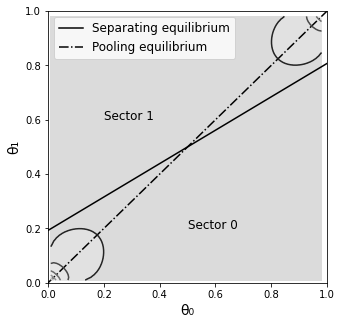

In [14]:
# Contour plot and equilibria distributions Gaussian copula ρ=0.7
kappa = 0.7
k = xx2.x[0]/xx2.x[1]
m = xx2.x[2]

fig, ax = plt.subplots(figsize=(5, 5))
d = np.arange(0, 1, 0.001)
vecfunc = np.vectorize(lambda x: (x-(1-k)/2)/k)
vecfunc2 = np.vectorize(lambda x: x)
x = np.arange(0.01,0.99,0.01)
y = np.arange(0.01,0.99,0.01)
X, Y = np.meshgrid(x,y)


zs = []
for i in np.arange(0.01,0.99,0.01):
    for j in np.arange(0.01,0.99,0.01):
        zs.append(acop(i,j,kappa))
zs = np.array(zs)
Z = zs.reshape(X.shape)
ax.contourf(X, Y, Z, cmap=plt.cm.gray,alpha=0.15)



ax.plot(vecfunc(d),d,label='Separating equilibrium',color='black')
vecfunc2 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc2(d), label='Pooling equilibrium',linestyle='dashdot',color='black')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('θ0'.translate(subscript))
ax.set_ylabel('θ1'.translate(subscript))
ax.legend(loc='upper left',prop={'size': 12})
plt.text(0.2, 0.6, 'Sector 1', fontsize=12)
plt.text(0.5, 0.2, 'Sector 0', fontsize=12)
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14)    
plt.contour(X,Y,Z)
plt.gray()
#plt.suptitle("Skill separation in competitive equilibria") 
plt.savefig('eqsepss.pdf')

In [104]:
# Area of integration limits, up=upper limit, dw=lower limit
up = 1
dw = 0

#For comparataive statics, change sigma
σ= 1
γ=1

# again cs for effects of changing the average skill level factor...
β=0
normd = 1

def beta_part(x):
    return 0-β*np.power(1-x,2)

# Determining the area of integration
def theta_det(x_h,x_l,θ,C):
    if θ==0:
        return dw
    elif θ==1:
        return pw
    meany = ( C + np.power( x_l, γ ) * np.exp( ndtri( [θ] )[0] ) ) / np.power( x_h, γ )
    out = 0 if meany<= 0 else norm.cdf( np.log( meany ) / σ )
    return out

# Determining the area of integration
def theta_det2(x_h,x_l,θ,C):
    if θ==0:
        return dw
    elif θ==1:
        return pw
    meany = ( C + np.power( x_l, γ ) * np.exp( σ*ndtri( [θ] )[0] ) ) / np.power( x_h, γ )
    out = 0 if meany<= 0 else norm.cdf( np.log( meany ) )
    return out

# Calculates the mass of workers in each sector and their allocation externality given input allocation externality and constant C
#For equilibirum first output should equal first input, same with second output, third and fourth output should be equal to zero.
def equilibrium_xs(x_h,x_l,C):
    out, err = integrate.dblquad(lambda x,y: acop(x,y,kappa), dw, up, lambda x: theta_det(x_h,x_l,x,C), up)
    out2, err2 = integrate.dblquad(lambda x,y: acop(x,y,kappa), dw, up, dw, lambda x: theta_det(x_h,x_l,x,C))
    ans_l, err0 = integrate.dblquad(lambda x,y: y*acop(x,y,kappa), dw, up, dw, lambda x: theta_det(x_h,x_l,x,C))
    ans_h, err1 = integrate.dblquad(lambda x,y: x*acop(x,y,kappa), dw, up, lambda x: theta_det(x_h,x_l,x,C), up)
    return np.array([2*ans_h, 2*ans_l, out, out2])

#Least squares solver with bounds to not let the allocation externality go to wilde. Guess is a tripllet of x0,x1 and C
def equilibrium_solve(beta, guess):
    global β
    β = beta
    return least_squares(lambda x: equilibrium_xs(x[0],x[1],x[2])-np.array([x[0],x[1],1/2,1/2]),  guess, bounds=[[0.1,0.1,0],[0.9,0.9, np.inf]])

# Go from wage level to worker type
def trans(w,x,sig):  
    return norm.cdf( np.log( w / np.power( x, γ ) ) / sig )


# The derivate of trans
def trans_diff(w,x,sig):
    return norm.pdf( np.log( w / np.power( x, γ ) ) / sig ) / ( sig * w  )

def mass_wage_sector(x,θ,C,deff):
    if deff == dw:
        sig = 1
        x_0, x_1 = x
        ans, err = integrate.quad(lambda x: acop(x,trans(θ,x_0,sig),kappa), dw, theta_det2(x_0,x_1,trans(θ,x_0, sig),C))
    elif deff == up:
        sig = σ
        x_1, x_0 = x
        ans, err = integrate.quad(lambda x: acop(trans(θ,x_0,sig),x,kappa), dw, theta_det(x_0,x_1,trans(θ,x_0, sig),-C))
    out = ans * trans_diff(θ,x_0, sig)
    return out

def summer(x,θ,C,sig):
    x_0, x_1 = x
    ans0, err = integrate.quad(lambda x: acop(x,trans(θ,x_0,sig),kappa), dw, theta_det(x_0,x_1,trans(θ,x_0,sig),C))
    if θ >= C + beta_part(x_1):
        ans1, err = integrate.quad(lambda x: acop(trans(θ,x_1,sig),x,kappa), dw, theta_det(x_1,x_0,trans(θ,x_1,sig),-C))
        return ans0* trans_diff(θ,x_0,sig) + ans1* trans_diff(θ,x_1,sig)
    else:
        return ans0 * trans_diff(θ,x_0,sig)

In [7]:
##### playing around and setting correct sigma
ab = fsolve(lambda x: (x*math.sqrt(0.8)+0.4)/math.sqrt(x**2+0.8)-0.85,  0.3)
x = ab[0]

print((x*math.sqrt(0.8)+0.4)/math.sqrt(x**2+0.8))
print(0.8,0.2,0.8+0.2)
print(0.5+math.sqrt(0.5**2-0.425**2), 0.425**2/(0.5+math.sqrt(0.5**2-0.425**2)),0.5+math.sqrt(0.5**2-0.425**2)+ 0.425**2/(0.5+math.sqrt(0.5**2-0.425**2)))
print(ab[0]**2, (x*math.sqrt(0.8)+0.4)/math.sqrt(x**2+0.8),ab)

0.8499999999999999
0.8 0.2 1.0
0.7633913438213185 0.23660865617868151 1.0
0.303886438693944 0.8499999999999999 [0.55125896]


In [40]:
# Solving for the separating equilibrium (good guess inserted)
normd = 1
eqk = np.array([])
for i in [0,1,2]:
    if i==0:
        γ = 1
        kappa = 0.8
        σ= 1
    elif i==1:
        γ = 1
        kappa = 0.85
        σ= math.sqrt(x**2+0.8)
    elif i==2:
        γ = 1
        kappa = 0.85
        σ= 1
    eqk = np.append(eqk,equilibrium_solve(0,[0.65,0.45,0.1]))
eqk

array([ active_mask: array([0, 0, 0])
               cost: 1.0713627504756134e-18
                fun: array([-2.32343922e-10,  3.40727335e-10,  9.55717283e-10, -1.02919928e-09])
               grad: array([ 1.72542052e-09, -1.81015191e-09, -2.37046971e-09])
                jac: array([[ 0.03711154, -1.12478294, -0.8910451 ],
              [-1.0518982 ,  0.14787893,  0.85232848],
              [ 1.05416781, -1.06901487, -1.44485972],
              [-1.05418576,  1.06898519,  1.44484441]])
            message: '`gtol` termination condition is satisfied.'
               nfev: 8
               njev: 8
         optimality: 2.3704697066495013e-09
             status: 1
            success: True
                  x: array([0.62303272, 0.51794094, 0.07137322])                                ,
        active_mask: array([0, 0, 0])
               cost: 7.898411127589599e-20
                fun: array([-5.28195265e-11, -7.99360578e-15,  2.78353229e-10,  2.78743251e-10])
               grad: arra

In [41]:
out1 = pd.DataFrame(eqk)
out1.to_pickle("eqks_csfinal")

In [105]:
dff = pd.read_pickle("eqks_csfinal")
a=dff[0].apply(pd.Series)
print(a[0:3].x[0],a[0:3].x[1],a[0:3].x[2])
#print(pd.read_pickle("eqks_csfinal222").apply(pd.Series)[0][0])

[0.62303272 0.51794094 0.07137322] [0.70146651 0.40031549 0.24344429] [0.67766931 0.43233885 0.18879898]


In [51]:
# Testing that this is in fact probability distributions
x_h, x_l, C = a[0:3].x[1]
γ = 1
kappa = 0.85
σ= math.sqrt(x**2+0.8)

print(integrate.dblquad(lambda x, y: trans_diff(y,x_l,1)*acop(trans(y,x_l,1),x,kappa), 0, 29, lambda y: 0, lambda y: theta_det(x_h,x_l,trans(y,x_l,1),C)))
print(integrate.dblquad(lambda x, y: trans_diff(y,x_h,σ)*acop(trans(y,x_h,σ),x,kappa), C, 29, lambda y: 0, lambda y: theta_det2(x_l,x_h,trans(y,x_h,σ),-C)))
#print(integrate.dblquad(lambda x,y: trans_diff(x,x_h,σ)*acop(trans_diff(x,x_h,σ),y,kappa), 0, 2, 
   #                     lambda x: 0, theta_det(x_h,x_l,trans_diff(x,x_h,σ),C)))

#print(integrate.dblquad(lambda x,y: trans_diff(x,x_l,1)*acop(trans_diff(x,x_l,1),y,kappa), 0, 2, lambda x: theta_det(x_l,x_h,trans_diff(x,x_l,1),-C), up))



(0.49999587126195544, 1.8341116625464338e-08)
(0.49980304009724785, 1.4874292369106285e-08)


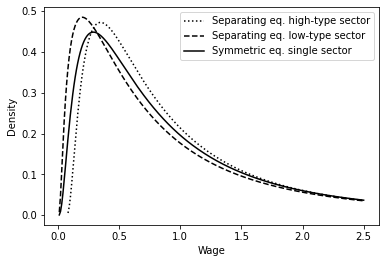

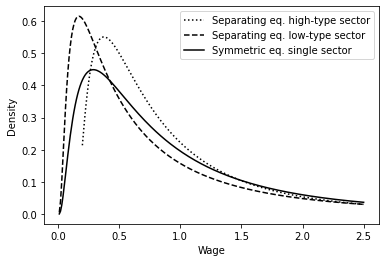

In [106]:
#Plotting wage distributions
normd = 1
β = 0
for i in [0,2]:
    if i == 0:
        kappa = 0.8
        σ = 1
        γ = 1
    elif i == 1:
        kappa = 0.85
        γ = 1
        σ = 1
        
    x_0, x_1, C = a[0:3].x[i]
    x = a[0:3].x[i][0:2]
    x_sym =equilibrium_xs(1,1,0)[0:2]
    
    d_low = np.arange(beta_part(x_0)+0.01, 2.5, 0.01)
    d_high = np.arange(C +beta_part(x_0)+0.01, 2.5, 0.01)
    d_med = np.arange(0.01+beta_part(x_sym[0]), 2.5, 0.01)
   
    low_wage = np.vectorize(lambda θ: mass_wage_sector(x,θ,C,0))(d_low)
    high_wage = np.vectorize(lambda θ: mass_wage_sector(x,θ,C,1))(d_high)
    med_wage = np.vectorize(lambda θ: mass_wage_sector(x_sym,θ,0,0))(d_med)

    fig, ax = plt.subplots()

    ax.plot(d_high,high_wage, label='Separating eq. high-type sector', color='black', linestyle='dotted')
    ax.plot(d_low,low_wage, label='Separating eq. low-type sector', color='black', linestyle='dashed')
    ax.plot(d_med,med_wage, label='Symmetric eq. single sector', color='black')

    plt.legend()
    #plt.title('Wage distributions in different eq')
    plt.xlabel('Wage')
    plt.ylabel('Density')
    plt.savefig('wd' + f'{str(i)}' +'final.pdf')    

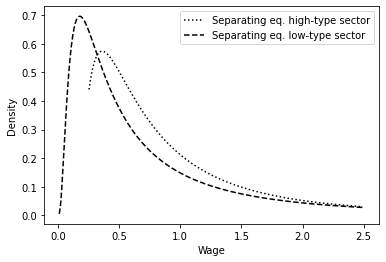

In [107]:
#Plotting wage distributions asym
ab = fsolve(lambda x: (x*math.sqrt(0.8)+0.4)/math.sqrt(x**2+0.8)-0.85,  0.3)
x = ab[0]
normd = 1
β = 0
γ = 1
kappa = 0.85
σ = math.sqrt(x**2+0.8)

        
x_0, x_1, C = a[0:3].x[1]
x = a[0:3].x[1][0:2]
d_low = np.arange(beta_part(x_0)+0.01, 2.5, 0.01)
d_high = np.arange(C +beta_part(x_0)+0.01, 2.5, 0.01)
    

low_wage = np.vectorize(lambda θ: mass_wage_sector(x,θ,C,0))(d_low)
high_wage = np.vectorize(lambda θ: mass_wage_sector(x,θ,C,1))(d_high)
    
fig, ax = plt.subplots()

ax.plot(d_high,high_wage, label='Separating eq. high-type sector', color='black', linestyle='dotted')
ax.plot(d_low,low_wage, label='Separating eq. low-type sector', color='black', linestyle='dashed')


plt.legend()
#plt.title('Wage distributions in different eq')
plt.xlabel('Wage')
plt.ylabel('Density')
plt.savefig('wd1final.pdf')    

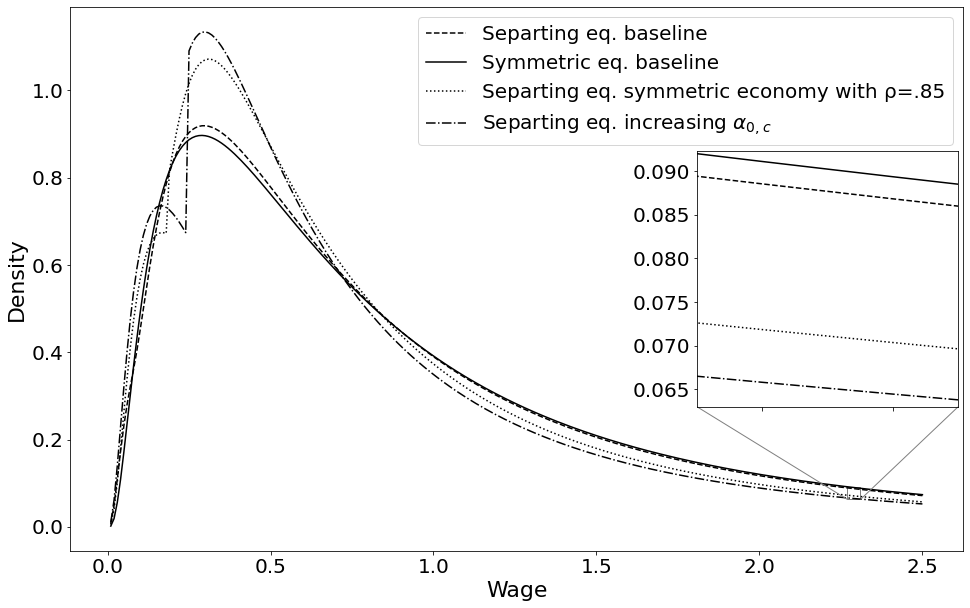

In [112]:
import matplotlib

string =r'Separting eq. increasing $α_{0,c}$'
kappa = 0.8
γ = 1
normd = 1
σ = 1
x_0, x_1, C = a[0:3].x[0]
x = a[0:3].x[0][0:2]
x_sym =equilibrium_xs(1,1,0)[0:2]
d_low = np.arange(beta_part(x_0)+0.01, 2.5, 0.01)

sum_wage = np.vectorize(lambda θ: summer(x,θ,C,σ))(d_low)
med_wage = np.vectorize(lambda θ: mass_wage_sector(x_sym,θ,0,0))(d_low)
sum_med_wage = 2*med_wage

fig, ax = plt.subplots(figsize=(16, 10))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
ax.plot(d_low,sum_wage, label='Separting eq. baseline' ,color='black', linestyle='dashed')
ax.plot(d_low,sum_med_wage, label='Symmetric eq. baseline',color='black')

kappa = 0.85
x_0, x_1, C = a[0:3].x[2]
x = a[0:3].x[2][0:2]

sum_wage_2 = np.vectorize(lambda θ: summer(x,θ,C,σ))(d_low)


ax.plot(d_low,sum_wage_2, label='Separting eq. symmetric economy with ρ=.85',color='black', linestyle='dotted')

ab = fsolve(lambda x: (x*math.sqrt(0.8)+0.4)/math.sqrt(x**2+0.8)-0.85,  0.3)
x = ab[0]
σ = math.sqrt(x**2+0.8)
x_0, x_1, C = a[0:3].x[1]
x = a[0:3].x[1][0:2]

sum_wage_3 = np.vectorize(lambda θ: summer(x,θ,C,σ))(d_low)


ax.plot(d_low,sum_wage_3, label=string, color='black', linestyle='dashdot')


plt.legend(fontsize=20)
plt.xlabel('Wage', size=22)
plt.ylabel('Density', size=22)

axins = zoomed_inset_axes(ax, 20, loc=7)
axins.plot(d_low,sum_wage,color='black', linestyle='dashed')
axins.plot(d_low,sum_med_wage, color='black')
axins.plot(d_low,sum_wage_2, linestyle='dotted',color='black')
axins.plot(d_low,sum_wage_3, linestyle='dashdot',color='black')

# sub region of the original image
x1, x2, y1, y2 = 2.27, 2.31, 0.063, 0.0923
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

plt.xticks(visible=False)
#plt.yticks(visible=False)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
#plt.title('Total wage distributions in different eq')

plt.savefig('twd2.pdf')

In [23]:
1.8743 / 3.436

0.545488940628638